In [77]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K

import numpy as np
import tensorflow_hub as hub

In [78]:
df = pd.read_csv("reviews.csv", usecols=["title","stars","text"])

In [79]:
df.head()

,stars,title,text
0,3,Not enough brownies!,"Super good, don't get me wrong. But I came for..."
1,5,I’m OBSESSED with this pint!,I decided to try it out although I’m not a hug...
2,3,My favorite...More Caramel Please,My caramel core begins to disappear about half...
3,5,Obsessed!!!,Why are people complaining about the blonde br...
4,1,Worst Ice Cream Ever!,This ice cream is worst ice cream I’ve ever ta...


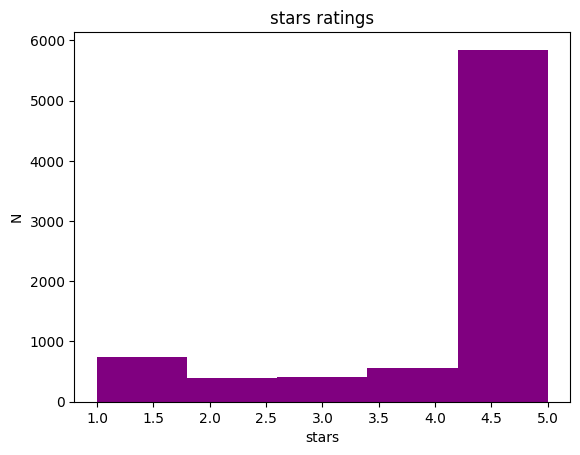

In [80]:
plt.hist(df.stars, bins=5, color='purple')
plt.title("stars ratings")
plt.xlabel("stars")
plt.ylabel("N")
plt.show()

In [81]:
df['stars'] = (df.stars >= 3).astype(int)
df = df[['stars', 'text']]

In [82]:
train,val,test = np.split(df.sample(frac=1), [int(len(df)*0.8), int(len(df)*0.9)])

In [83]:
len(train),len(val), len(test)

(6354, 794, 795)

In [84]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('stars')
  df = df["text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [85]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)


In [86]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [87]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.21042852, -0.17065684,  0.0537295 , ...,  0.08036362,
         0.14085473,  0.18476614],
       [ 0.23610526, -0.14300208,  0.017524  , ..., -0.12515257,
         0.14161241,  0.27093247],
       [ 0.05522003, -0.01418682,  0.15607147, ..., -0.01247844,
        -0.14687313,  0.02270666],
       ...,
       [ 0.17633367,  0.03400281, -0.11982178, ..., -0.12492526,
         0.22469395,  0.14623062],
       [ 0.17365438,  0.00297242, -0.29908267, ..., -0.08603258,
         0.3065593 ,  0.2186317 ],
       [ 0.18413651, -0.04733314, -0.01545446, ...,  0.20889118,
        -0.07893348, -0.06198053]], dtype=float32)>

#Build the Model

In [88]:
model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(16,activation="relu"))

model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

#Compile the Model


In [89]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(),
metrics=['accuracy'])

In [90]:
model.evaluate(train_data)

7/7 [==============================] - 1s 27ms/step - loss: 0.6454 - accuracy: 0.8396


[0.6453837752342224, 0.8396285772323608]

In [91]:
model.evaluate(valid_data)

1/1 [==============================] - 0s 66ms/step - loss: 0.6451 - accuracy: 0.8338


[0.64512038230896, 0.8337531685829163]

#Train Model

In [92]:
history = model.fit(train_data,epochs=5, validation_data=valid_data)

Epoch 1/5
7/7 [==============================] - 11s 1s/step - loss: 0.6233 - accuracy: 0.7506 - val_loss: 0.5804 - val_accuracy: 0.8476
Epoch 2/5
7/7 [==============================] - 12s 2s/step - loss: 0.5670 - accuracy: 0.8192 - val_loss: 0.5195 - val_accuracy: 0.8476
Epoch 3/5
7/7 [==============================] - 11s 2s/step - loss: 0.5232 - accuracy: 0.8410 - val_loss: 0.4730 - val_accuracy: 0.8476
Epoch 4/5
7/7 [==============================] - 11s 2s/step - loss: 0.4914 - accuracy: 0.8532 - val_loss: 0.4438 - val_accuracy: 0.8476
Epoch 5/5
7/7 [==============================] - 10s 2s/step - loss: 0.4620 - accuracy: 0.8547 - val_loss: 0.4261 - val_accuracy: 0.8476


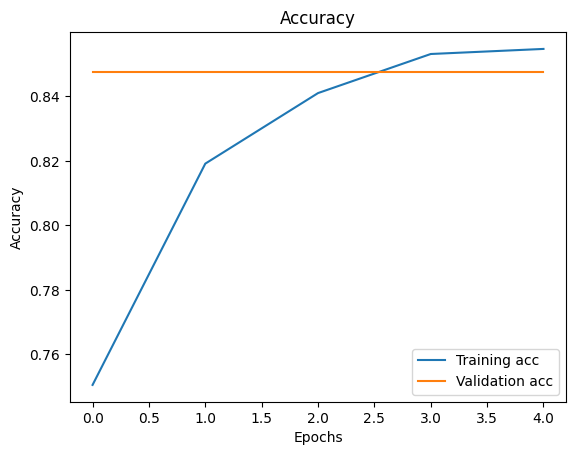

In [93]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


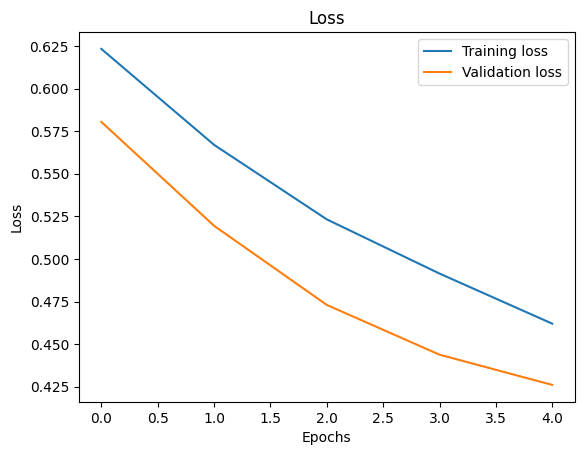

In [95]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()